# **Unrolling diffusion models for image inverse problems**
 
 
For many problems in imaging, we are interested in recovering an image of interest, $x \in \mathbb{R}^d$, from a set of measurements $y \in \mathbb{R}^d$. These two are related through a statistical model with likelihood function
of the form
 
$$p(y|x) = e^{-f_{y}(x)}\,\,,$$
 
where $f_{y}$ is a data fidelity term. This class includes important observation models, in particular Gaussian linear models of the form
 
$$y = Ax + w\,\,,$$
 
where $A \in \mathbb{R}^{d \times d}$ is a linear operator and $w \sim \mathcal{N}(0, \sigma^2 I_d)$ is a noise term.  Here, we study the case where both $A$ and the noise variance $\sigma>0$ are known.
 
However, the recovery of $x$ from $y$ is often ill-posed or ill-conditioned, so regularisation is required in order to deliver meaningful solutions. In the Bayesian framework, this is achieved by using prior knowledge about $x$. Since $x$ is a realisation of a random variable $\mathbb{X}$, it admits a probability distribution with density $p(x)$, which model prior information about $x$.
 
Considering the likelihood model $p(y|x)$ and prior $p(x)$, and by using the Bayes theorem we are able to deriver the posterior distribution as follows
 
$$p(x|y) = \dfrac{p(y|x)p(x)}{p(y)}, \quad p(y) = \int_{\mathbb{R}^d}p(y|x)p(x)dx. $$
 
The purpose is to solve either the following maximum-a-posteriori (MAP) estimation problem
$$\hat{x}_{MAP} \in \argmax_{x\in\mathbb{R}^d} p(x|y),$$
or implementing a posterior sampling algorithm to compute the minimum mean square error (MMSE)
$$\hat{x}_{MMSE} = \int_{\mathbb{R}^d}xp(x|y)dx.$$
 
### Score-based generative models
Over the past years, score-based diffusion models have been used to model data distribution $p_{\text{data}}$ by reversing the following stochastic differential equation (SDE)
$$dX_t = -\frac{\beta_t}{2}X_tdt + \sqrt{\beta_t}dW_t, \quad X_0 \sim p_{\text{data}},$$
where
* $\beta_t>0$ is a noise scheduler
* $W_t$ is a $d-$dimensional Browinan motion
 
The backward SDE associated to this forward SDE is defined by
$$dX_t = -\left(\frac{\beta_t}{2}X_t + \beta_t \nabla_{x_t}\log p_t(X_t)\right)dt + \sqrt{\beta_t}d\bar{W}_t, \quad X_{\infty} \sim \mathcal{N}(0,I),$$
where
* $\bar{W}_t$ represents a d-dimensional Brownian motion running backward with $t$ flowing from infinity to $0$
* $x_t\mapsto \nabla_{x_t}\log p_t(x_t)$ is the score function of the marginal distribution $p_t$ at timestep $t$.
 
Denoising diffusion models seek to use training data $\{x^{(i)}\}_{i=1}^M$ and denoising score-matching techniques to find an estimator of $x_t\mapsto \nabla_{x_t}\log p_t(x_t)$ and them draw sample from $p_{\text{data}}$ by reversing the backward SDE.
 
In discrete setting, the transistion of the forward SDE is given by
$$p(x_t|x_{t-1}) = \mathcal{N}(x_t;\sqrt{1-\beta_t}x_{t-1}, \beta_t I) \quad \text{ and } x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon_t, \epsilon_t\sim \mathcal{N}(0,I).$$
Similarly, the tranisition of the backward process is parametrized by a neural network as follows
$$p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1};\mu_\theta(x_t,t), \tilde{\beta}_t),$$
where
* $\mu_\theta(x_t,t)$ is a neural network with learnable parameters $\theta$
* $\tilde{\beta}_t>0$ is the noise parameter at timestep $t$.
 
 
## Methodology
 
In this framework, we want to decouple the prior term from the likelihood term. This is achieved by introducing an auxiliary variable $z$ related to $x$ as follows
 
\begin{equation}
x = z + \omega_0, \quad \text{ where } \omega_0 \sim \mathcal{N}(0,\rho^2I) \text{ with } \rho>0.
\end{equation}
 
The transition from $x$ (for simplicity, $x = x_0$) to the noisy image $x_t$, $t>0$, is given by
 
\begin{equation}
x_t = \sqrt{\bar{\alpha}_t}x + \sqrt{1-\bar{\alpha}_t}\epsilon_t, \quad \text{ where } \epsilon_t \sim \mathcal{N}(0,I).
\end{equation}
 
Since we want the restore a high-quality image from the observation $y$, we redefine the conditional backward SDE by replacing $\nabla_{x_t}\log p(x_t)$ with $\nabla_{x_t}\log p(x_t|y)$ as follows
\begin{equation}
    dX_t = -(\frac{\beta_t}{2}X_t + \beta_t \nabla_{x_t}\log p(X_t|y))dt + \sqrt{\beta_t}d\bar{W}_t.
\end{equation}
In this case, we approximate the conditional score $\nabla_{x_t}\log p(x_t|y)\propto p(y|x_t)p(x_t)$ by using the Tweedie identity as follows
\begin{equation}
    \nabla_{x_t}\log p(x_t|y) = \dfrac{x_t - \sqrt{\bar{\alpha}_t} \mathbb{E}[x|x_t,y]}{1-\bar{\alpha}_t}
\end{equation}
 
The main objective of the work is to design and train a conditional diffusion model that efficiently approaximate $\mathbb{E}[x|x_t,y]$. We recall that
 
\begin{equation}
\mathbb{E}[x|x_t,y] = \int_{\mathbb{R}^d}\int_{\mathbb{R}^d}xp(x,z|x_t,y)dx,
\end{equation}
where
* $p(x,z|x_t,y) \propto p(y|x)p(x_t|x)p(x|z)$.
* $p(x_t|x) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t}x, (1-\bar{\alpha}_t)I)$.
* $p(x|z) = \mathcal{N}(x; z, \rho^2I)$.
* $p(y|x) = \mathcal{N}(y; Ax, \rho^2I)$.
* $\alpha_t = 1-\beta_t$ and $\bar{\alpha}_t = \prod_{s=1}^t\bar{\alpha}_t$.
* $0\leq\beta_0<\beta_1<\dots< \beta_T\leq 1$, $T\in\mathbb{N}$.
 
Introducing the auxiliary variable $z$ enable us to split the estimation problem in two subproblems,
\begin{equation}
    \text{Pb: 1}\,\,\quad \hat{x} = \argmax_{x\in\mathbb{R}^d}p(y|x)p(x_t|x)p(x|z),
\end{equation}
 
\begin{equation}
    \text{Pb: 2}\,\,\quad \hat{z} = \argmax_{z\in\mathbb{R}^d} p(x|z)p(z).
\end{equation}
 
* PB: 1 is an optimization problem that involves the likelihood term and the noisy image $x_t$.
* PB: 2 is a denoising problem with $p(z)$ is the data prior.
 
## **Unrolling Algorithm at timestep $t$**
 
 
**$\mathcal{T}^L_{\Delta\theta}$: Input** $z^0, x^0, x_t, y$,
 
**Output** $z^L,x^L$
 
**for** $l = 0,1,\dots, L-1$ **do**
 
$\quad (1) \quad x^{l+1} \leftarrow \boxed{\argmax_{x\in\mathbb{R}^d}p(y|x^l)p(x_t|x^l)p(x^l|z^l)}$
 
$\quad(2) \quad z^{l+1} \leftarrow \boxed{G_{\Delta\theta}(x^l; \hat{t})} \quad$  
 
**end for**
 
Where
* $G_{\Delta\theta}$ is a pre-trained denoising diffusion model and $\Delta\theta$ is the LoRA parameters.
* $\hat{t}$ is the corresponding timestep of $x^l$ in the diffusion process.
 
### **Training $\mathcal{T}_\theta$**
 
Our training procedure involves two networks: the pre-trained diffusion model $G_{\Delta\theta}$ and a conditional discriminator $D_\phi(.,y)$. During training, the unrolling model $\mathcal{T}^L_{\Delta\theta}$ generates $\hat{x}_{\Delta\theta}(x_t)$ from $x_t$ and $y$. For the adversarial objective, the generated samples $\hat{x}_{\Delta\theta}$ and real images $x$ are passed to the conditional discriminator $D_\phi$ which aims to distinguish between them.
 
We train ${\Delta\theta}$ and $\phi$ by alternatively minimizing the following objective
 
$$ \argmin_{\Delta\theta} \mathbb{E}_{x,y}\left[ D_\phi(\mathcal{T}^L_{\Delta\theta}(x_t,y),y) + \text{LPIPS}(\mathcal{T}_{\Delta\theta}(x_t,y), x)\right]$$
 
$$ \argmax_{\phi} \mathbb{E}_{x,y}\left[D_\phi(x;y) - D_\phi(\mathcal{T}^L_\theta(x_t,y)) + \gamma \mathcal{L}(\phi)\right],$$
 
where
* LPIPS is the Learned Perceptual Image Patch Similarity metric,
* $\mathcal{L}(\phi)$ is gradient penality loss used to enforced sparsity in $D_\phi$.
* $\gamma>0$ is a regularisation parameter.
 
 
### **Inference**
 
**Algorithm $\mathcal{T}^L_{\Delta\theta}$: Input** $z^0, x^0, x_t, y$,
 
**Output** $z^L,x^L$
 
**for** $t = T-1,\dots, 1,0$ **do**
 
$\quad (1) \quad x_{\Delta\theta}(x_t), z_{\Delta\theta}(x_t) = \mathcal{T}^L_{\Delta\theta}(x^0, z^0, x_t, y)$
 
$\quad(2) \quad x_{t-1} = \text{DDIM}(x_t, x_{\Delta\theta}(x_t))$  
 
$\quad(3) \quad z^0,x^0 = z_{\Delta\theta}(x_t), x_{\Delta\theta}(x_t)$
 
**end for**

In [1]:
import os
import sys
import copy
import time
import yaml
import numpy as np
import pandas as pd
import blobfile as bf
import matplotlib.pyplot as plt
import datetime
import scipy.io as sio
import torch
from torch.utils.data import DataLoader
os.chdir('/users/cmk2000/cmk2000/Deep learning models/LLMs/Regularised_CDM')
sys.path.append(os.getcwd())
print("Current working directory:", os.getcwd())

from datasets.datasets import GetDatasets
import models as models
import utils as utils
import unfolded_models as ums
import physics as phy
import runners as runners
from configs.args_parse import configs
from metrics.coverage.coverage_function import coverage_eval
from metrics.metrics import Metrics

import argparse

Current working directory: /users/cmk2000/cmk2000/Deep learning models/LLMs/Regularised_CDM


/users/cmk2000/.conda/envs/dmog_env39/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/users/cmk2000/.conda/envs/dmog_env39/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:

def configsargs():
    parser = argparse.ArgumentParser(description=globals().get("__doc__", "Argument parser for the script"))
    
    parser.add_argument("--config_file", type=str, default="fine_tuning_lmodel.yaml", help="configs file")
    parser.add_argument("--task", type=str, default="deblur", help="Task we are solving")
    parser.add_argument("--operator_name", type=str, default="gaussian", help="Type of operator used!!")
    parser.add_argument("--lambda_", type=float, default=0.32, help="parameter controlling data consistency step!!")
    parser.add_argument("--ckpt_epoch", type=int, default=129, help="Epoch where the model is resumed")
    parser.add_argument("--sigma_model", type=float, default=0.05, help="Noise variance of the model")
    parser.add_argument("--ckpt_date", type=str, default="11-03-2025", help="Date when the checkpoint was saved")
    parser.add_argument("--total_steps", type=int, default=3, help="Total timesteps")

    config, _ = parser.parse_known_args()
    
    return config




In [ ]:
LORA = True
max_unfolded_iter = 3
eta =0.0  
T_AUG = 0
zeta = 0.1
date_eval = datetime.datetime.now().strftime("%d-%m-%Y")

script_dir = os.getcwd()
config = configsargs()
print(os.path.join(script_dir,"configs", config.config_file))
with open(os.path.join(script_dir, "configs", config.config_file), 'r') as file:
    config_dict = yaml.safe_load(file)
args = utils.dict_to_dotdict(config_dict)


args.task = config.task
args.physic.operator_name = config.operator_name 
args.physic.sigma_model = config.sigma_model

ckpt_epoch = config.ckpt_epoch
ckpt_date = config.ckpt_date
if config.task == "inp":
    args.dpir.use_dpir = config.use_dpir

args.lambda_ = config.lambda_
args.lora = LORA
args.evaluation.coverage = False
args.ddpm_param = 1.0
args.solver_type = "ddim"
args.eta = eta
args.use_wandb = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
args.device = device

args.zeta = zeta
args.max_unfolded_iter = max_unfolded_iter
args.date = ckpt_date
args.epoch = ckpt_epoch
args.eval_date = date_eval
args.save_wandb_img = False

args.lora_checkpoint_dir = bf.join(args.save_checkpoint_dir, args.task, ckpt_date, args.physic.operator_name) 
args.lora_checkpoint_name = f"checkpoint_lora_{args.task}_epoch={ckpt_epoch:03d}.ckpt"

/users/cmk2000/cmk2000/Deep learning models/LLMs/Regularised_CDM/configs/fine_tuning_lmodel.yaml


### Load test data

In [5]:
# data
dir_test = "/users/cmk2000/sharedscratch/Datasets/testsets/imageffhq" #/users/cmk2000/sharedscratch/Datasets/testsets/ffhq or imageffhq
datasets = GetDatasets(dir_test, args.im_size)
testset = DataLoader(datasets, batch_size=1, shuffle=False)



/users/cmk2000/.conda/envs/dmog_env39/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### load model

In [6]:
model = models.adapter_lora_model(args)    
models.load_trainable_params(model, args)

/users/cmk2000/cmk2000/Deep learning models/LLMs/Regularised_CDM/guided_diffusion/dist_util.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return th.load(io.BytesIO(da

Number of Layers frozen: 362
Total trainable parameters of the model: 93563910 (non-LoRa) vs 61440 (LoRa) Ratio: 0.07% of the original model


/users/cmk2000/cmk2000/Deep learning models/LLMs/Regularised_CDM/models/load_model.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trainable_state_dict = torch.load(fil

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stri

### Create modules

* `kernels`: generates the blur kernel discribing the intrument (e.g., camera, telescope, MRI device)
* `physic`: This module, we 
    * define the forward operator from the blur kernel. 
    * generate the observation $y$
    * compute the posterior mean $\mathbb{E}[x|y,x_t, z]$
    * compute the posterior variance $\mathbb{V}[x|y,x_t, z]$

In [ ]:
# Kernels
kernels = phy.Kernels(
    operator_name=args.physic.operator_name,
    kernel_size=args.physic.kernel_size,
    device=device,
    mode = args.mode
)

# Physics
physic = phy.Deblurring(
    sigma_model=args.physic.sigma_model,
    device=device,
    scale_image=args.physic.transform_y,
    operator_name=args.physic.operator_name,
)

* `DiffusionScheduler`: Here, we set the timestep $t$, noise scheduler $\beta_t$ and other important parameters.
* `GetDenoisingTimestep`: In this module, we compute $\hat{t}$ and other important parameters.
* `HQS_models`: In this module we implemented the unrolling algorithm.
* `Conditional_sampler`: Here, we inplemented the posterior sampling algorithm.

In [8]:
# Diffusion noise module
diffusion_scheduler = ums.DiffusionScheduler(device=device,noise_schedule_type=args.noise_schedule_type)

# HQS module
denoising_timestep = ums.GetDenoisingTimestep(device)
hqs_module = ums.HQS_models(
    model,
    physic, 
    diffusion_scheduler, 
    denoising_timestep,
    args
)
    
# sampler module
diffsampler = runners.Conditional_sampler(
    hqs_module, 
    physic, 
    diffusion_scheduler, 
    device, 
    args,
    max_unfolded_iter = max_unfolded_iter
)

/users/cmk2000/cmk2000/Deep learning models/LLMs/Regularised_CDM/DPIR/dpir_models.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/users/cmk2000/.conda/envs/dmog_env39/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/cmk2000/.conda/envs/dmog_env39/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /users/cmk2000/.conda/envs/dmog_env39/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth


/users/cmk2000/.conda/envs/dmog_env39/lib/python3.12/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_pa

### Evaluation metrics

In [ ]:
# Metrics
metrics = Metrics(device=device)

/users/cmk2000/.conda/envs/dmog_env39/lib/python3.12/site-packages/torchmetrics/functional/image/lpips.py:325: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_

### Get a blur kernel
In this notebook, we consider a Gaussian deblurring problems, where blur kernel is defined as follows
$$h(u,v) = \dfrac{1}{2\pi\sigma^2}e^{-\dfrac{u^2+v^2}{2\sigma^2}}

In [11]:
# Blur kernel 
blur = kernels.get_blur(seed=1234)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2148897..1.0511585].


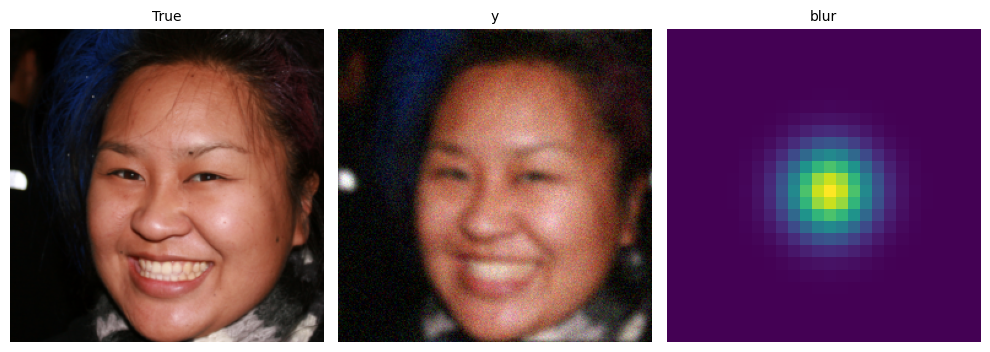

In [20]:
for i, im in enumerate(testset):
    # True image
    im_name = f"{(i):05d}"
    im = im.to(device)
    x = utils.inverse_image_transform(im).squeeze().permute(1,2,0)
    x_true = None

    # observation y 
    obs = physic.y(im, blur)

    obs = obs.add(1).div(2).squeeze().permute(1,2,0)

    # Create a subplot
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(x)  
    axes[0].set_title(f"True", fontsize=15) 
    axes[0].axis("off")  

    axes[1].imshow(obs)  
    axes[1].set_title(f"y", fontsize=15) 
    axes[1].axis("off")  

    axes[2].imshow(blur)  
    axes[2].set_title(f"blur", fontsize=15) 
    axes[2].axis("off")  


    plt.tight_layout()  
    plt.show()
    
    break

In [22]:
psnr_temp_y = metrics.psnr_function(obs, x)

In [23]:
psnr_temp_y 

array(23.925201, dtype=float32)

#### hyper-parameters

In [12]:
max_iter = 1
num_timesteps=3

### Main loop

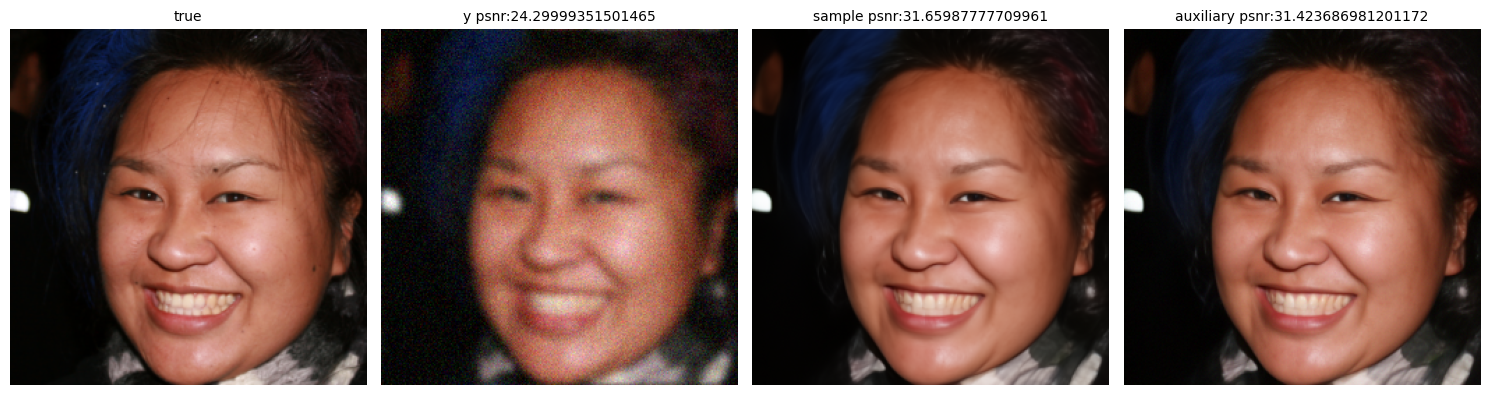

In [ ]:

for ii, im in enumerate(testset):
    if ii>0:
        continue
        
    # True image
    im_name = f"{(ii):05d}"
    im = im.to(device)
    x = utils.inverse_image_transform(im)
    x_true = None
    
    # observation y 
    y = physic.y(im, blur)
    
    for it in range(max_iter):
        start_time = time.time()
        out = diffsampler.sampler(
            y, 
            im_name, 
            num_timesteps = num_timesteps, 
            eta=eta, 
            zeta=zeta,
            x_true = x_true,
            lambda_ = args.lambda_
        )
        # collapsed time
        collapsed_time = time.time() - start_time           

    # posterior mean - mmse
    X_posterior_mean = out["xstart_pred"]
    
    # evalauations
    psnr_temp_sample = metrics.psnr_function(X_posterior_mean, x)
    psnr_temp_aux = metrics.psnr_function(out["aux"], x)
    psnr_temp_y = metrics.psnr_function(utils.inverse_image_transform(y), x)
    
    images = [utils.get_rgb_from_tensor(x),utils.get_rgb_from_tensor(utils.inverse_image_transform(y)), utils.get_rgb_from_tensor(X_posterior_mean), utils.get_rgb_from_tensor(out["aux"])]
    titles = ["true", "y", "sample", "auxiliary"]
    psnrs = [None, psnr_temp_y, psnr_temp_sample, psnr_temp_aux]
    
    # Create a subplot
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for jj, ax in enumerate(axes):
        img = images[jj]  
        psnr_val = psnrs[jj] 
        ax.imshow(img)  
        if psnr_val is not None:
            ax.set_title(f"{titles[jj]} psnr:{psnr_val}", fontsize=10) 
        else:
            ax.set_title(f"{titles[jj]}", fontsize=10) 
        ax.axis("off")  

    plt.tight_layout()  
    plt.show()

    
     

## **Box inpainting**

$$y = Ax + \omega$$

where 
* $A$ represents the box mask operator
* $\omega\sim \mathcal{N}(0,\sigma^2I)$

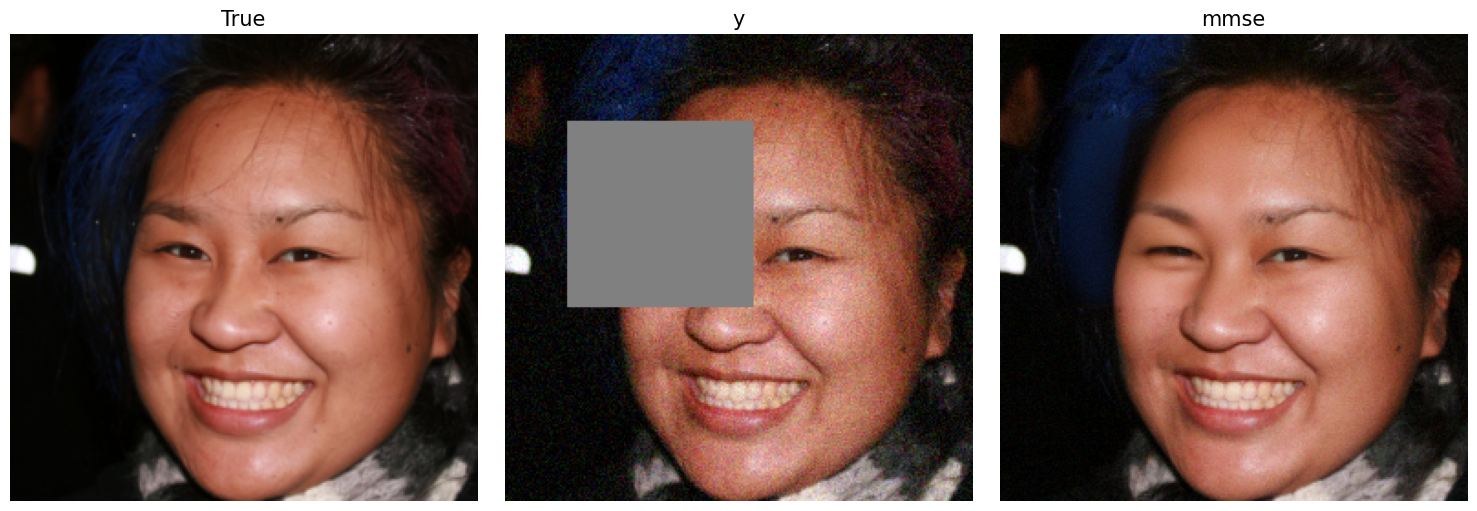

In [11]:
import cv2
import matplotlib.pyplot as plt
path=lambda folder: f"/users/cmk2000/sharedscratch/CKM/Regularised_CDM/Results/inp_lora/operator_box/03-03-2025/ddim/Max_iter_1/timesteps_10/zeta_0.1/eta_0.0/lambda_0.0005/{folder}/00000.png"

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
x_true = cv2.imread(path("ref"))
x_true = torch.from_numpy(x_true).float().flip([2])/255.
axes[0].imshow(x_true)  
axes[0].set_title(f"True", fontsize=15) 
axes[0].axis("off")  

y_inp = cv2.imread(path("y"))
y_inp = torch.from_numpy(y_inp).float().flip([2])/255.
axes[1].imshow(y_inp)  
axes[1].set_title(f"y", fontsize=15) 
axes[1].axis("off")  

mmse_inp = cv2.imread(path("mmse"))
mmse_inp = torch.from_numpy(mmse_inp).float().flip([2])/255.
axes[2].imshow(mmse_inp)  
axes[2].set_title(f"mmse", fontsize=15) 
axes[2].axis("off")  

plt.tight_layout()  
plt.show()

## **Random inpainting**

$$y = Ax + \omega$$

where 
* $A$ represents the random mask operator
* $\omega\sim \mathcal{N}(0,\sigma^2I)$

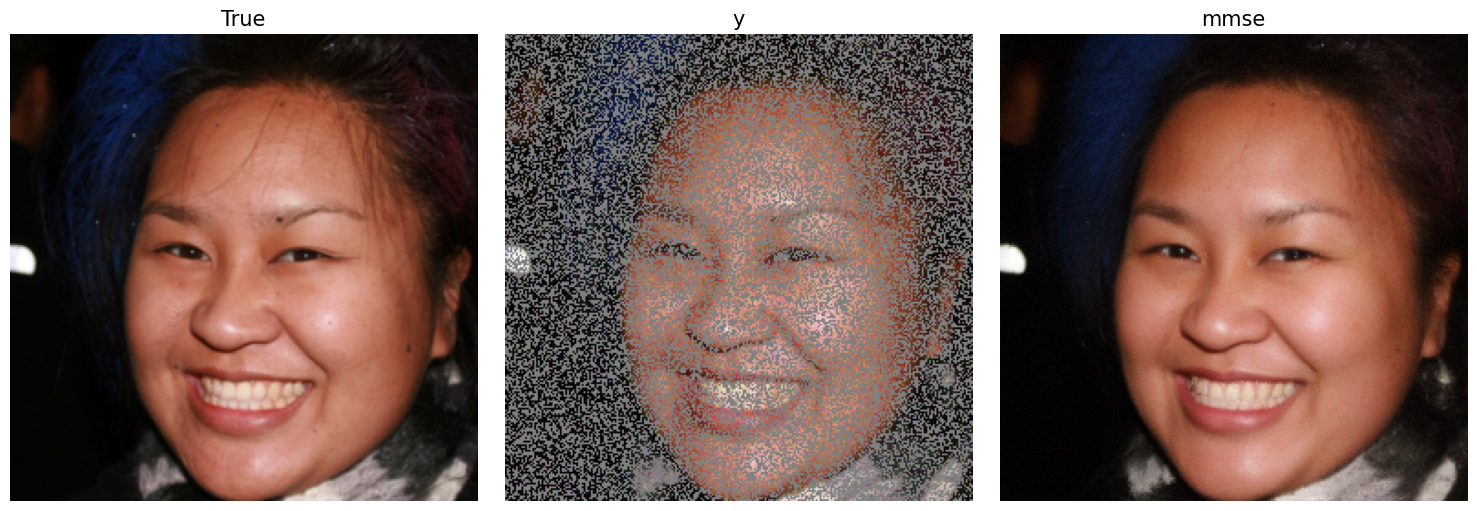

In [12]:
import cv2
import matplotlib.pyplot as plt
path=lambda folder: f"/users/cmk2000/sharedscratch/CKM/Regularised_CDM/Results/inp_lora/operator_random/25-03-2025/ddim/Max_iter_1/timesteps_50/zeta_0.1/eta_0.0/lambda_0.0005/{folder}/00000.png"

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
x_true = cv2.imread(path("ref"))
x_true = torch.from_numpy(x_true).float().flip([2])/255.
axes[0].imshow(x_true)  
axes[0].set_title(f"True", fontsize=15) 
axes[0].axis("off")  

y_inp = cv2.imread(path("y"))
y_inp = torch.from_numpy(y_inp).float().flip([2])/255.
axes[1].imshow(y_inp)  
axes[1].set_title(f"y", fontsize=15) 
axes[1].axis("off")  

mmse_inp = cv2.imread(path("mmse"))
mmse_inp = torch.from_numpy(mmse_inp).float().flip([2])/255.
axes[2].imshow(mmse_inp)  
axes[2].set_title(f"mmse", fontsize=15) 
axes[2].axis("off")  

plt.tight_layout()  
plt.show()

## **Super resolution** 

$$y = SAx + \omega$$

where 
* $S$ is a downsampling operator 
* $A$ represents the forward operator
* $\omega\sim \mathcal{N}(0,\sigma^2I)$

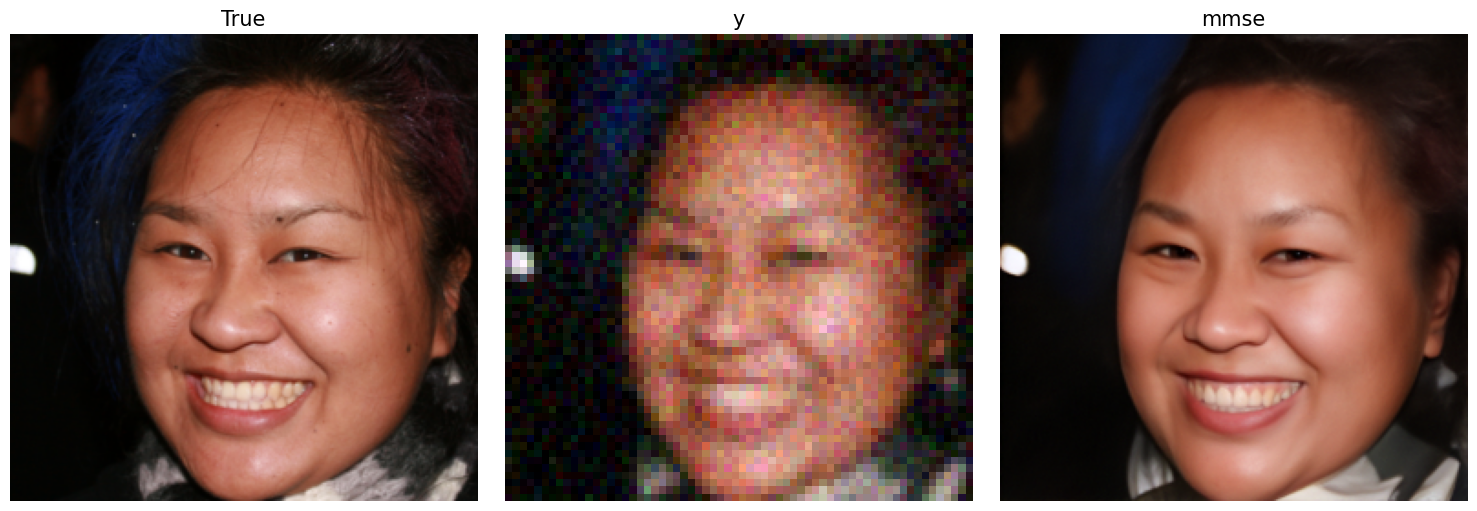

In [13]:
import cv2
import matplotlib.pyplot as plt
path=lambda folder: f"/users/cmk2000/sharedscratch/CKM/Regularised_CDM/Results/sr_lora/operator_gaussian/25-02-2025/ddpm/Max_iter_1/timesteps_3/ddpm_param_1.0/lambda_10.0/{folder}/00000.png"

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
x_true = cv2.imread(path("ref"))
x_true = torch.from_numpy(x_true).float().flip([2])/255.
axes[0].imshow(x_true)  
axes[0].set_title(f"True", fontsize=15) 
axes[0].axis("off")  

y_inp = cv2.imread(path("y"))
y_inp = torch.from_numpy(y_inp).float().flip([2])/255.
axes[1].imshow(y_inp)  
axes[1].set_title(f"y", fontsize=15) 
axes[1].axis("off")  

mmse_inp = cv2.imread(path("mmse"))
mmse_inp = torch.from_numpy(mmse_inp).float().flip([2])/255.
axes[2].imshow(mmse_inp)  
axes[2].set_title(f"mmse", fontsize=15) 
axes[2].axis("off")  

plt.tight_layout()  
plt.show()

In [14]:
import time 

start_time = time.time()

In [15]:
-start_time +time.time()

7.071106433868408

In [1]:
import cv2

# Load video
video_path = "/users/cmk2000/cmk2000/Deep learning models/LLMs/Regularised_CDM/notebooks/32.mp4"  # Change this to your video file
cap = cv2.VideoCapture(video_path)

frame_count = 0  # Counter for frames


frame_interval = 10  # Extract every 10th frame

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    if frame_count % frame_interval == 0:
        frame_filename = f"frame_{frame_count:04d}.jpg"
        cv2.imwrite(frame_filename, frame)

    frame_count += 1


In [2]:
im_pth = "/users/cmk2000/cmk2000/Deep learning models/LLMs/Regularised_CDM/notebooks/frame_0700.jpg"

H = cv2.imread(im_pth)

In [3]:
H.shape

(720, 1280, 3)